## Noise vs F-score

In this code the database from Quian Quiroga is used for studying the effect of the noise in 
the performance of different spike sorting algorithms with just different dimmensionality reduction techniques.

The code uses the functions developed by Viktor Arseni

In [17]:
# importing libraries
import numpy as np
from scipy.io import loadmat
#import spikeforest as sf
import matplotlib.pyplot as plt
#from busz_funcs import pk, pts_extraction, butter_bandpass_filter_zi, load_kachery
#from toposort.preprocessing import spike_denoiser as denoiser, spike_aligner as aligner
import umap
import hdbscan
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA 
#from quiroga import *
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import random
#import umap.plot
import pywt
from scipy import stats
import pickle as pkl        # probably Vik needs to install this library, 
import SpkSort as s
from os import path as p
from os import listdir
#plt.style.use('fivethirtyeight')
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!

# FOr silencing warnings
import warnings
warnings.filterwarnings("ignore")
print("done")

done


In [18]:
path="/media/sparra/HDD/article_spike_sorting/Simulator/"
namefiles1= ( ("C_Easy1_noise01.mat", 0.1),
             ("C_Easy1_noise02.mat", 0.2),
             ("C_Easy1_noise03.mat", 0.3),
            ("C_Easy1_noise04.mat", 0.4),
            ("C_Easy1_noise005.mat", 0.05),
            ("C_Easy1_noise015.mat", 0.15),
            ("C_Easy1_noise025.mat", 0.25),
            ("C_Easy1_noise035.mat", 0.35))

namefiles2= (("C_Difficult2_noise01.mat", 0.1),
            ( "C_Difficult2_noise02.mat", 0.2),
            ("C_Difficult2_noise005.mat", 0.05),
             ("C_Difficult2_noise015.mat", 0.15))

namefiles3=(("C_Difficult1_noise01.mat", 0.1),
             ("C_Difficult1_noise02.mat", 0.2),
             ("C_Difficult1_noise005.mat", 0.05),
             ("C_Difficult1_noise015.mat", 0.15))

namefiles4=(("C_Burst_Easy2_noise015.mat", 0.15),)

namefiles5=(("C_Drift_Easy2_noise015.mat", 0.15),)

files={"easy":namefiles1, "difficult1":namefiles3, "difficult2":namefiles2,
      "bursty":namefiles4, "drifting":namefiles5}

## Analysing files per type

Note that, due to wavelets decomposition and wavelets just add descriptors but the initial ones do not change by adding just more components in contrast with umap, where adding new components, in fact change the behaviour in less dimensions. Then, the best option is calculate separately both methods, first the linear ones and after the non-linear.

In [68]:
# Parameters for this script
min_features=2            # Minimimum dimensionality or # of components to explore.
maximum_features=15       # Maximum dimensionality to explore
fscore_results={}         # dictionary where results will be saved
clasification={}
delta=25                  # Parameter to indicate if both spikes are the same shifted in samples (delta*0.04166667 in ms)
types_file=files.keys()   # Types of file. see above cell

avoid=( )  #("easy", "difficult1", "difficult2")
list_existing_files=listdir()

for type_i in types_file:
    # if type_i in avoid:
    #     continue
    # if "%s_from_%d_to_%d_pca_wav.pkl"%(type_i, min_features, maximum_features) in list_existing_files:
    #     print("file: %s_from_%d_to_%d_pca_wav.pkl exists.  Skipping "%(type_i, min_features, maximum_features))
    #     continue
    print("Executing %s files"%(type_i))
    for file_i in files[type_i]:   
        # Dictionary with results per type of file
        print("\tAnalyzing %s file"%(file_i[0]))
        fscore_results[file_i[0]]={"noise":file_i[1],
                        "pca": np.zeros((maximum_features-min_features)), 
                        "umap": np.zeros(maximum_features-min_features), 
                        "waveclus": np.zeros(maximum_features-min_features)}  
        spikes, labels, spike_times = s.load_quiroga_spikes(p.join(path, file_i[0]) )  
        clusters=np.unique(labels)
        denoised = s.denoiser(spikes)
        spikes2 = s.aligner(denoised, alignment="tukey", window_length=30, upsample_rate=8)
        # Calculating values with the whole set
        reducer_waveclus = s.waveclus(spikes2, maximum_features)
        reducer_pca= PCA(maximum_features).fit_transform(spikes2)
        for dim_i in range(min_features, maximum_features):
            clusterer_waveclus= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_waveclus[:, 0:dim_i])
            clasification["waveclus"]= clusterer_waveclus.labels_
            #  sep per technique
            clusterer_pca= hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_pca[:, 0:dim_i])
            clasification["pca"]= clusterer_pca.labels_
            
            reducer_umap= umap.UMAP(min_dist=0, n_neighbors=4, n_components=dim_i, n_epochs=2000, random_state=0, metric="manhattan").fit(spikes2)
            umap_emb = reducer_umap.embedding_.copy()
            clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5, cluster_selection_epsilon=.6).fit(reducer_umap.embedding_)
            clasification["umap"] = clusterer_umap.labels_
            # Now measure f-score per file and techinique
            #raise ValueError("Aqui vamos")
            for technique_i in classification.keys():
                fscore_tmp=s.f_recording(spike_times, labels, clasification[technique_i], delta, return_conf_mat=False)
                fscore_results[file_i[0]][technique_i][dim_i-min_features]=fscore_tmp
                
# Saving results to a file
with open("Analysis_from_%d_to_%d_pca_wav.pkl"%(min_features, maximum_features), "wb") as file1:
    pkl.dump(fscore_results, file1)
print("Finished...")

Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise03.mat file
	Analyzing C_Easy1_noise04.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
	Analyzing C_Easy1_noise025.mat file
	Analyzing C_Easy1_noise035.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Executing bursty files
	Analyzing C_Burst_Easy2_noise015.mat file
Executing drifting files
	Analyzing C_Drift_Easy2_noise015.mat file
Finished...


## Now plotting results 

Horizontal axes should be dimmension while vertical axis would be the F-score mean for all files
The next script will produce pictures per noise level as kind of file and or all of them.



In [13]:
namefiles_saved= ("bursty_from_2_to_15_pca_wav.pkl", 
                  "difficult1_from_2_to_15_pca_wav.pkl", 
                  "difficult2_from_2_to_15_pca_wav.pkl",
                  "drifting_from_2_to_15_pca_wav.pkl",
                  "easy_from_2_to_15_pca_wav.pkl")

data=[]
for file_i in namefiles_saved:
    with open(file_i, "rb") as f:
        data_tmp=pkl.load(f)
    data.append(data_tmp)

print("Data loaded successfully...")

Data loaded successfully...


## Plotting easy files.

In [15]:
data[0]

{'C_Easy1_noise01.mat': {'noise': 0.1,
  'pca': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'umap': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'waveclus': array([0.77742846, 0.77742846, 0.77742846, 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        ])},
 'C_Easy1_noise02.mat': {'noise': 0.2,
  'pca': array([0.77521677, 0.77620924, 0.7767796 , 0.77688499, 0.77263007,
         0.76897215, 0.77272469, 0.77672747, 0.77520268, 0.77017159,
         0.77277321, 0.77177768, 0.77285743]),
  'umap': array([0.98737332, 0.98778059, 0.98737332, 0.98815195, 0.98737332,
         0.98815195, 0.98815195, 0.98815195, 0.98815195, 0.98815195,
         0.98833419, 0.98815195, 0.9900469 ]),
  'waveclus': array([0.77612478, 0.77629364, 0.77629364, 0.77629364, 0.77620924,
         0.77604025, 0.77604025, 0.76053022, 0.76424661, 0.76424661,
         0.76424661, 0.76442637, 0.7647865 ])},


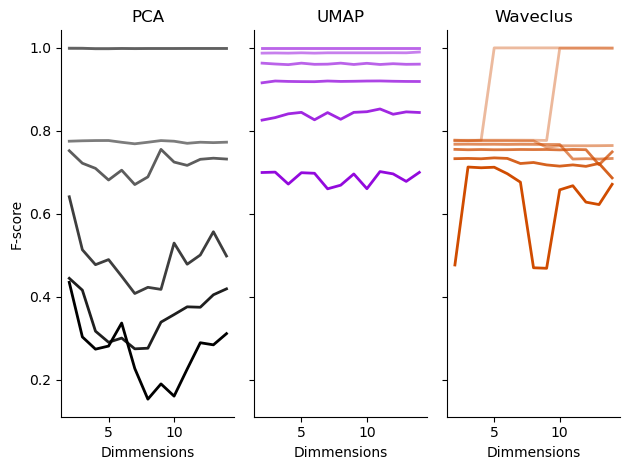

In [3]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
noise_level=np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
alpha=np.linspace(0.15, 1, 8)
x=np.arange(2, 15)

reducer=("pca", "umap", "waveclus")
fig, ax=plt.subplots(1, 3, sharex=True, sharey=True)
for file_i in data[4].keys():
    for idx, method_i in enumerate(reducer):
        text="Noise: %.2f"%(data[4][file_i]["noise"])
        idx_alpha=np.argmin(np.abs(noise_level - data[4][file_i]["noise"]))
        ax[idx].plot(x, data[4][file_i][method_i], #label=text, 
                     c=colors[idx], alpha=alpha[idx_alpha], lw=2)
        #ax[idx].legend(loc="best", frameon=False)

for ax_i in range(3):
    ax[ax_i].spines[['right', 'top']].set_visible(False)
    ax[ax_i].set_xlabel("Dimmensions")
ax[0].set_title("PCA")
ax[1].set_title("UMAP")
ax[2].set_title("Waveclus")
ax[0].set_ylabel("F-score")
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'     # Export svg text as text and not paths!
fig.savefig("f-scorevsDimm_easyfiles.svg")


I am going to include an analysis saving the confusion matrix for the f-score.

In [13]:
run script_confusion_matrix.py

Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise03.mat file
	Analyzing C_Easy1_noise04.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
	Analyzing C_Easy1_noise025.mat file
	Analyzing C_Easy1_noise035.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Executing bursty files
	Analyzing C_Burst_Easy2_noise015.mat file
Executing drifting files
	Analyzing C_Drift_Easy2_noise015.mat file


NameError: name 'score_results' is not defined

In [4]:
run difficulty_vs_dimmensions.py

Executing easy files
	Analyzing C_Easy1_noise01.mat file
	Analyzing C_Easy1_noise02.mat file
	Analyzing C_Easy1_noise03.mat file
	Analyzing C_Easy1_noise04.mat file
	Analyzing C_Easy1_noise005.mat file
	Analyzing C_Easy1_noise015.mat file
	Analyzing C_Easy1_noise025.mat file
	Analyzing C_Easy1_noise035.mat file
Executing difficult1 files
	Analyzing C_Difficult1_noise01.mat file
	Analyzing C_Difficult1_noise02.mat file
	Analyzing C_Difficult1_noise005.mat file
	Analyzing C_Difficult1_noise015.mat file
Executing difficult2 files
	Analyzing C_Difficult2_noise01.mat file
	Analyzing C_Difficult2_noise02.mat file
	Analyzing C_Difficult2_noise005.mat file
	Analyzing C_Difficult2_noise015.mat file
Executing bursty files
	Analyzing C_Burst_Easy2_noise015.mat file
Executing drifting files
	Analyzing C_Drift_Easy2_noise015.mat file
Finished...


## Plots about difficulty

In the next cell the results about the difficulty of datasets for clustering after dimmensionality reduction is shown.
Consider the following:

We used two metrics: Silhouette and DaviesBOuldin index for the data according to the ground truth.

The idea is to evaluate how difficult the dataset is for a clustering based on which dimmensionality reduction was used, then this is an indirect measure about how good the technique is for clustering applications.

Both metrics rely on two components: 1) The simmmilitude or distance between the elments of the same cluster, and 2) the minimum distance between elements of different clusters.

In [ ]:
run plot_difficulty.py

## Bursty and drifting

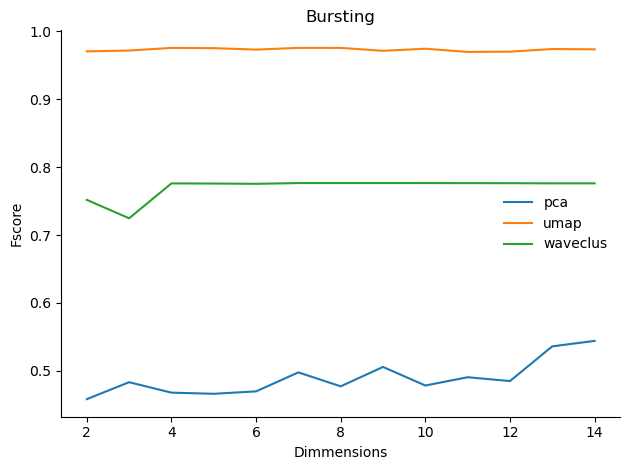

In [12]:
run burstin_plot.py

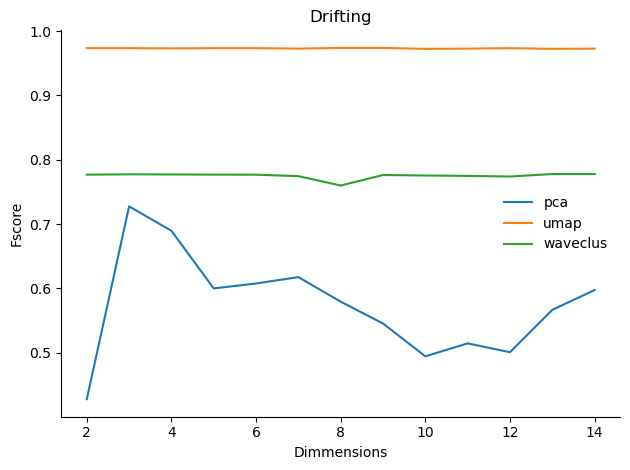

In [11]:
run Plot_drifting.py

Now plotting f-score as a function of noise, keep all dimensions.

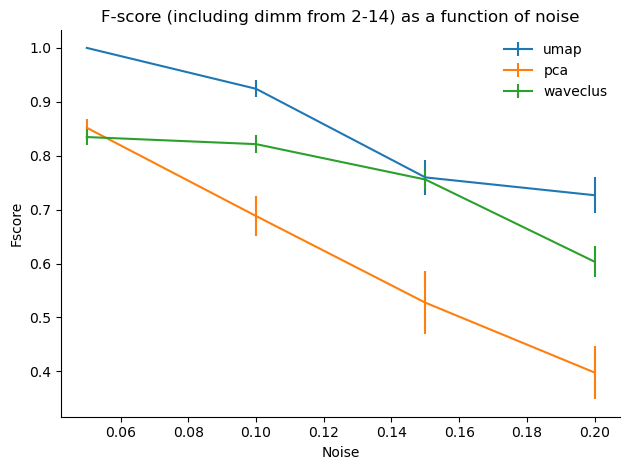

{'umap': array([1.        , 1.        , 0.99963079, 0.98810348, 0.96139166,
       0.91925392, 0.83979443, 0.68721883]), 'pca': array([1.        , 1.        , 0.99860462, 0.77376366, 0.71746544,
       0.49139558, 0.35351317, 0.26752843]), 'waveclus': array([0.94870063, 0.94863734, 0.8626937 , 0.77044449, 0.75692497,
       0.75173752, 0.72219704, 0.62886719])}


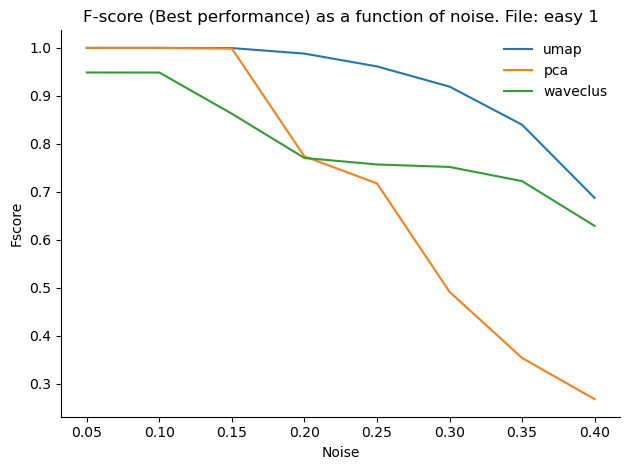

In [9]:
run plotting_fscoreVsnoise.py

The first plot above shows the f-score as a function of noise considering files:easy1, hard1, and hard2. 
In the picture is shown the mean over all dimmensions to get an agnostic value about the performance. errorbars are the sem (standard error of the mean)

The second picture shows the values by using just the file easy1. There are more points, but there is only one value per noise.



The following section will manage deletions in order to get an approximate about the silent neurons. All neurons have a stationary firing rate around 25 Hz (checar este valor). So, considering this, and deleting spikes, how well will be de the performance of the classifiers?

